# setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as at

In [3]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 123

# load data

In [4]:
behaviorTable = pd.read_csv('D:/code/lab/csv tables/behaviorTableExp2.csv') 
# hand error
hand_err = behaviorTable.errorCorrect.values

numTrials = int(behaviorTable['trialNum'].max())
numSubjects = int(hand_err.shape[0]/numTrials)

# Reshape hand_err to match the structure of (numSubjects, numTrials)
y_reshaped = np.reshape(hand_err, (numSubjects, numTrials))
# Define perturbation pattern
pert_zero = np.zeros(50)
pert_minus_30 = np.full(80, -30)
pertSize = np.concatenate((pert_zero, pert_minus_30, pert_zero[:20]))

In [5]:
# Choose a subject to fit the model
subject_index = 0
y_subject = y_reshaped[subject_index]

# create test data

In [5]:
# params
A_test = 0.9
B_test = 0.01

# eta,eps
eta_test = np.random.normal(0, 1, numTrials)
eps_test = np.random.normal(0, 1, numTrials)

# initialize x y
x_test = np.zeros(numTrials)
y_test = np.zeros(numTrials)
x_test[0] = eta_test[0]
y_test[0] = x_test[0] + eps_test[0]

# create y
for t in range(numTrials - 1):
    x_test[t + 1] = (A_test * x_test[t]) + (B_test * y_test[t]) + eta_test[t]

    y_test[t + 1] = x_test[t + 1] + pertSize[t + 1] + eps_test[t + 1]

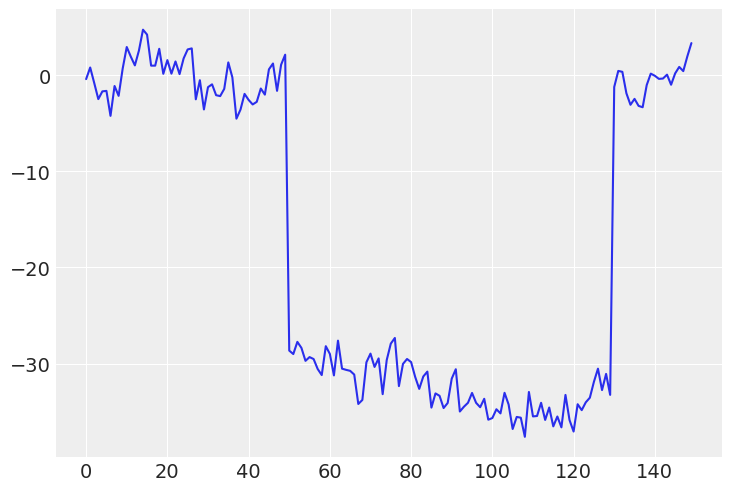

In [6]:
plt.plot(y_test)

In [7]:
# Use pytensor.scan to loop 
with pm.Model() as model_test:
    # priors
    A = pm.Normal('A', mu=0.5, sigma=0.5)
    B = pm.Normal('B', mu=0.5, sigma=0.5)
    eta = pm.Normal('eta', mu=0, sigma=1, shape=numTrials)
    eps = pm.Normal('eps', mu=0, sigma=1, shape=numTrials)
    
    x0 = pm.Deterministic('x0', eta[0])
    outputs_info = at.as_tensor_variable(x0)
    pertSize = at.as_tensor_variable(pertSize)
    A = at.as_tensor_variable(A)
    B = at.as_tensor_variable(B)
    eta = at.as_tensor_variable(eta)
    eps = at.as_tensor_variable(eps)
    
    def one_step(P_tm1, eps_tm1, eta_tm1, x_tm1, A, B):
        return (A + B) * x_tm1 + B * P_tm1 + B * eps_tm1 + eta_tm1

    outputs, updates = pytensor.scan(
        fn=one_step,
        sequences=[pertSize, eps, eta],
        outputs_info=outputs_info,
        non_sequences=[A, B],
        n_steps=numTrials
    )

    yn = pm.Deterministic('yn', outputs + pertSize + eps)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=yn, sigma=2, observed=y_test)

In [8]:
trace_test = pm.sample(1000, tune=1000, target_accept=0.95, nuts={"max_treedepth": 20}, model=model_test)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B, eta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 502 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
az.summary(trace_test, round_to=2, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.86,0.05,0.77,0.95,0.00,0.00,1372.59,2248.60,1.0
B,0.01,0.01,0.00,0.02,0.00,0.00,1626.65,2465.28,1.0
eta[0],-0.20,0.63,-1.47,0.95,0.01,0.01,4440.72,3160.02,1.0
eta[1],-0.11,0.89,-1.93,1.54,0.01,0.01,5300.94,3249.46,1.0
eta[2],-0.45,0.88,-2.15,1.29,0.01,0.01,4995.86,3076.88,1.0
...,...,...,...,...,...,...,...,...,...
yn[145],0.24,1.22,-2.16,2.59,0.02,0.02,6384.18,3485.27,1.0
yn[146],0.63,1.24,-1.59,3.22,0.02,0.02,6130.85,3338.18,1.0
yn[147],0.78,1.27,-1.67,3.30,0.01,0.02,7302.70,3239.42,1.0
yn[148],1.36,1.25,-1.00,3.86,0.02,0.01,5670.30,3393.51,1.0


Sampling: [y_obs]


<Axes: xlabel='y_obs / y_obs'>

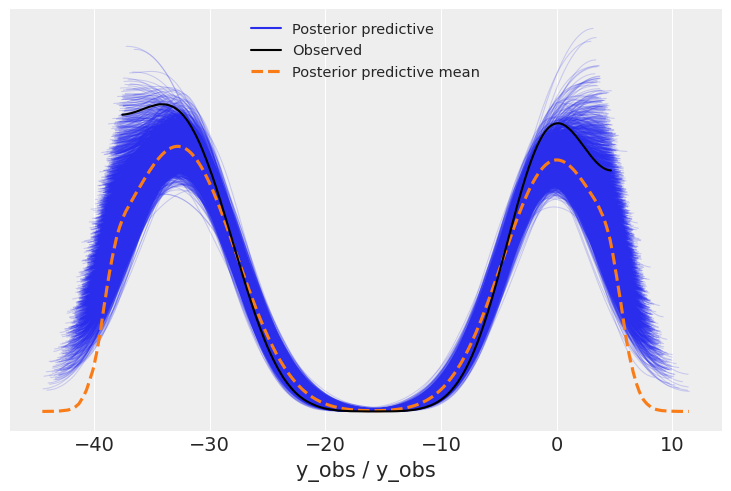

In [11]:
ppc_test = pm.sample_posterior_predictive(trace_test, model=model_test)
az.plot_ppc(ppc_test, mean=True)

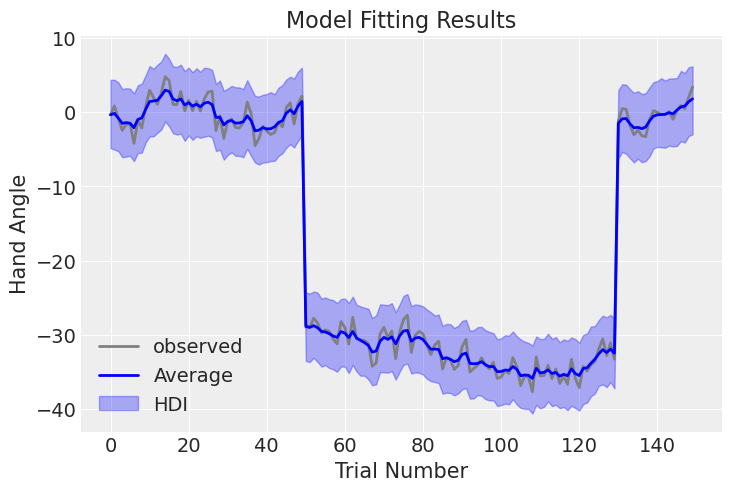

In [12]:
# Plot fitting result
# Calculate mean and HDI
y_mean = ppc_test['posterior_predictive'].mean(dim=['chain','draw'])
y_observe = ppc_test['observed_data']
hdi = az.hdi(ppc_test['posterior_predictive']['y_obs'], hdi_prob=0.95)
# Separate lower and upper bounds
hdi_low = hdi.sel(hdi='lower')
hdi_high = hdi.sel(hdi='higher')

# Plot average hand angle
plt.plot(y_observe.y_obs, color='grey', linewidth=2, label='observed')
plt.plot(y_mean.y_obs, color='blue', linewidth=2, label='Average')

# Plot HDI
plt.fill_between(range(numTrials), hdi_low.y_obs, hdi_high.y_obs, color='blue', alpha=0.3, label='HDI')

plt.xlabel('Trial Number')
plt.ylabel('Hand Angle')
plt.title('Model Fitting Results')
plt.legend()
plt.show()

# model 1 - without noise

In [5]:
# Use pytensor.scan to loop (To simplify, ignore the 2 noise items)
with pm.Model() as model1:
    # priors
    A = pm.Normal('A', mu=0.5, sigma=0.5)
    B = pm.Normal('B', mu=0.5, sigma=0.5)
    
    x0 = 0
    outputs_info = at.as_tensor_variable(np.asarray(x0, dtype='float64'))
    pertSize = at.as_tensor_variable(pertSize)
    A = at.as_tensor_variable(A)
    B = at.as_tensor_variable(B)
    
    def one_step(P_tm1, x_tm1, A, B):
        return (A + B) * x_tm1 + B * P_tm1

    outputs, updates = pytensor.scan(
        fn=one_step,
        sequences=[dict(input=pertSize)],
        outputs_info=outputs_info,
        non_sequences=[A, B],
        n_steps=numTrials
    )

    yn = pm.Deterministic('yn', outputs + pertSize)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=yn, sigma=3, observed=y_subject)

In [6]:
trace1 = pm.sample(1000, tune=1000, target_accept=0.95, nuts={"max_treedepth": 20}, model=model1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


In [7]:
az.summary(trace1, round_to=2, hdi_prob=0.95)

D:\miniforge3\envs\pymc5_pytensor\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.55,0.09,0.38,0.71,0.0,0.0,717.37,552.65,1.01
B,0.06,0.01,0.04,0.08,0.0,0.0,724.28,547.61,1.00
yn[0],0.00,0.00,0.00,0.00,0.0,0.0,4000.00,4000.00,NaN
yn[1],0.00,0.00,0.00,0.00,0.0,0.0,4000.00,4000.00,NaN
yn[2],0.00,0.00,0.00,0.00,0.0,0.0,4000.00,4000.00,NaN
...,...,...,...,...,...,...,...,...,...
yn[145],-0.01,0.01,-0.02,-0.00,0.0,0.0,737.49,604.89,1.00
yn[146],-0.00,0.01,-0.02,-0.00,0.0,0.0,737.13,604.89,1.00
yn[147],-0.00,0.01,-0.01,-0.00,0.0,0.0,736.78,605.93,1.00
yn[148],-0.00,0.00,-0.01,-0.00,0.0,0.0,736.32,605.93,1.00


Sampling: [y_obs]


<Axes: xlabel='y_obs / y_obs'>

D:\miniforge3\envs\pymc5_pytensor\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
D:\miniforge3\envs\pymc5_pytensor\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


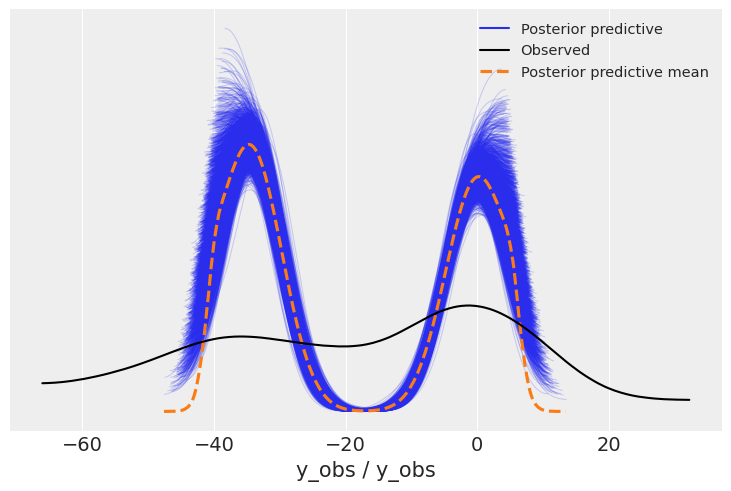

In [8]:
ppc1 = pm.sample_posterior_predictive(trace1, model=model1)
az.plot_ppc(ppc1, mean=True)

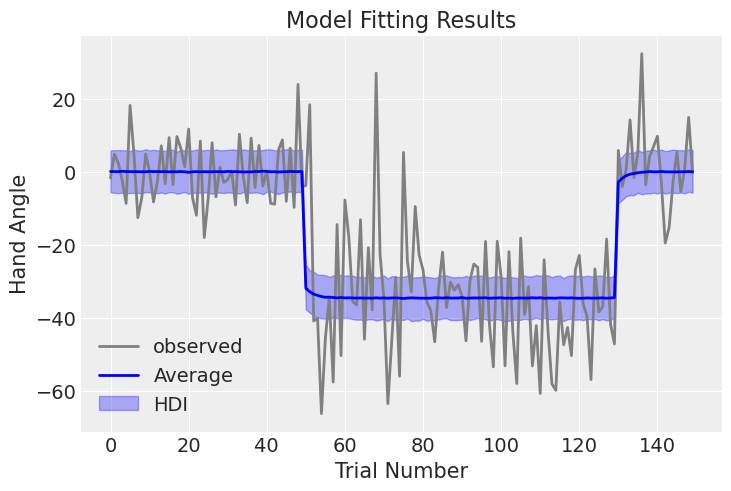

In [9]:
# Plot fitting result
# Calculate mean and HDI
y_mean = ppc1['posterior_predictive'].mean(dim=['chain','draw'])
y_observe = ppc1['observed_data']
hdi = az.hdi(ppc1['posterior_predictive']['y_obs'], hdi_prob=0.95)
# Separate lower and upper bounds
hdi_low = hdi.sel(hdi='lower')
hdi_high = hdi.sel(hdi='higher')

# Plot average hand angle
plt.plot(y_observe.y_obs, color='grey', linewidth=2, label='observed')
plt.plot(y_mean.y_obs, color='blue', linewidth=2, label='Average')

# Plot HDI
plt.fill_between(range(numTrials), hdi_low.y_obs, hdi_high.y_obs, color='blue', alpha=0.3, label='HDI')

plt.xlabel('Trial Number')
plt.ylabel('Hand Angle')
plt.title('Model Fitting Results')
plt.legend()
plt.show()

# model 2 - with noise

In [10]:
# Use pytensor.scan to loop 
with pm.Model() as model2:
    # priors
    A = pm.Normal('A', mu=0.5, sigma=0.5)
    B = pm.Normal('B', mu=0.5, sigma=0.5)
    eta = pm.Normal('eta', mu=0, sigma=1, shape=numTrials)
    eps = pm.Normal('eps', mu=0, sigma=1, shape=numTrials)
    
    x0 = pm.Deterministic('x0', eta[0])
    outputs_info = at.as_tensor_variable(x0)
    pertSize = at.as_tensor_variable(pertSize)
    A = at.as_tensor_variable(A)
    B = at.as_tensor_variable(B)
    eta = at.as_tensor_variable(eta)
    eps = at.as_tensor_variable(eps)
    
    def one_step(P_tm1, eps_tm1, eta_tm1, x_tm1, A, B):
        return (A + B) * x_tm1 + B * P_tm1 + B * eps_tm1 + eta_tm1

    outputs, updates = pytensor.scan(
        fn=one_step,
        sequences=[pertSize, eps, eta],
        outputs_info=outputs_info,
        non_sequences=[A, B],
        n_steps=numTrials
    )

    yn = pm.Deterministic('yn', outputs + pertSize + eps)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=yn, sigma=3, observed=y_subject)

In [11]:
trace2 = pm.sample(1000, tune=1000, target_accept=0.95, nuts={"max_treedepth": 20}, model=model2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B, eta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 209 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
az.summary(trace2, round_to=2, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.35,0.92,-1.29,0.93,0.46,0.35,7.24,28.65,1.53
B,0.11,0.15,0.01,0.38,0.07,0.06,7.19,29.24,1.53
eta[0],0.14,0.79,-1.38,1.71,0.02,0.01,1970.92,175.54,1.01
eta[1],0.38,0.91,-1.34,2.21,0.01,0.01,5374.71,2914.20,1.00
eta[2],-0.08,0.91,-1.78,1.73,0.01,0.01,5678.31,3101.14,1.00
...,...,...,...,...,...,...,...,...,...
yn[145],0.15,1.56,-2.77,3.32,0.24,0.17,43.71,180.31,1.06
yn[146],-0.78,1.54,-3.65,2.37,0.02,0.02,6313.19,3529.98,1.00
yn[147],0.42,1.67,-3.15,3.44,0.32,0.23,27.85,72.84,1.09
yn[148],3.34,1.61,0.31,6.63,0.11,0.09,236.60,2114.14,1.02


Sampling: [y_obs]


<Axes: xlabel='y_obs / y_obs'>

D:\miniforge3\envs\pymc5_pytensor\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
D:\miniforge3\envs\pymc5_pytensor\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


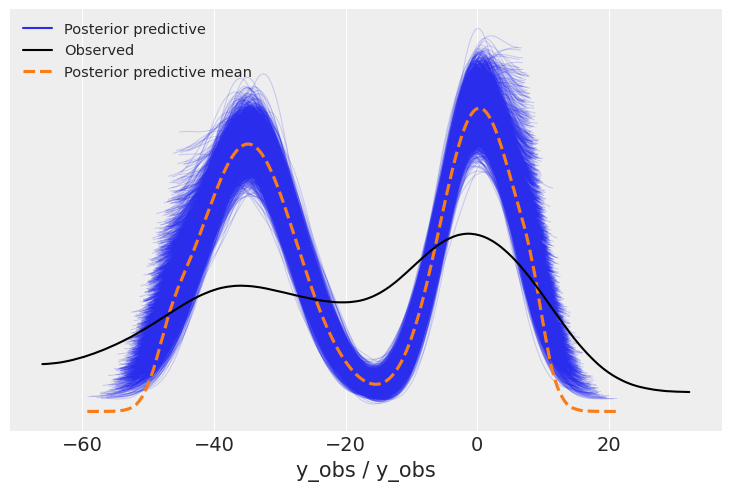

In [13]:
ppc2 = pm.sample_posterior_predictive(trace2, model=model2)
az.plot_ppc(ppc2, mean=True)

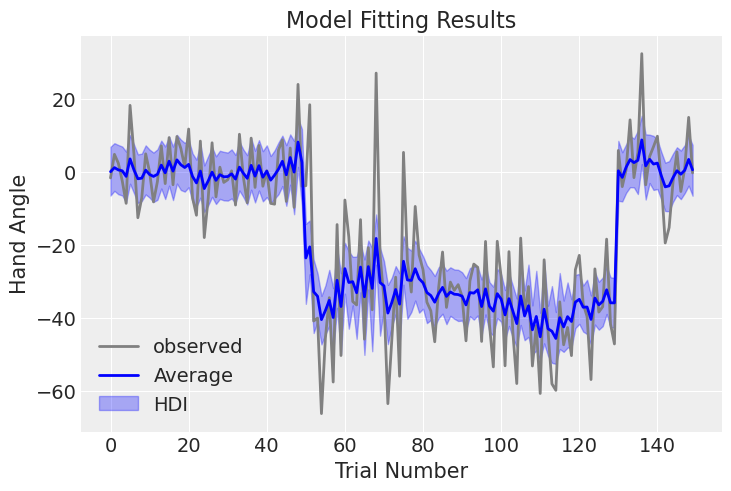

In [14]:
# Plot fitting result
# Calculate mean and HDI
y_mean = ppc2['posterior_predictive'].mean(dim=['chain','draw'])
y_observe = ppc2['observed_data']
hdi = az.hdi(ppc2['posterior_predictive']['y_obs'], hdi_prob=0.95)
# Separate lower and upper bounds
hdi_low = hdi.sel(hdi='lower')
hdi_high = hdi.sel(hdi='higher')

# Plot average hand angle
plt.plot(y_observe.y_obs, color='grey', linewidth=2, label='observed')
plt.plot(y_mean.y_obs, color='blue', linewidth=2, label='Average')

# Plot HDI
plt.fill_between(range(numTrials), hdi_low.y_obs, hdi_high.y_obs, color='blue', alpha=0.3, label='HDI')

plt.xlabel('Trial Number')
plt.ylabel('Hand Angle')
plt.title('Model Fitting Results')
plt.legend()
plt.show()

# model 3 - explicit loop

In [13]:
with pm.Model() as model3:
    # Priors
    A = pm.Normal('A', mu=0.5, sigma=0.5)
    B = pm.Normal('B', mu=0.5, sigma=0.5)
    eta = pm.Normal('eta', mu=0, sigma=0.1, shape=numTrials)
    eps = pm.Normal('eps', mu=0, sigma=0.1, shape=numTrials)

    # Iterative loop for generating x and y
    x = [pm.Deterministic(f'x_{0}', eta[0])]
    y = [pm.Deterministic(f'y_{0}', x[0] + eps[0])]
    
    for t in range(1, numTrials):
        x.append(pm.Deterministic(f'x_{t}', A * x[-1] + B * y[-1] + eta[t-1]))
        y.append(pm.Deterministic(f'y_{t}', x[-1] + pertSize[t] + eps[t]))

    x_rv = pm.math.stack(x)
    y_rv = pm.math.stack(y)
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=y, sigma=3, observed=y_subject)

In [14]:
trace3 = pm.sample(1000, tune=1000, target_accept=0.95, nuts={"max_treedepth": 20}, model=model3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [ ]:
az.summary(trace3, round_to=2, hdi_prob=0.95)

In [ ]:
ppc3 = pm.sample_posterior_predictive(trace3, model=model3)
az.plot_ppc(ppc3, mean=True)

In [ ]:
# Plot fitting result
# Calculate mean and HDI
y_mean = ppc3['posterior_predictive'].mean(dim=['chain','draw'])
y_observe = ppc3['observed_data']
hdi = az.hdi(ppc3['posterior_predictive']['y_obs'], hdi_prob=0.95)
# Separate lower and upper bounds
hdi_low = hdi.sel(hdi='lower')
hdi_high = hdi.sel(hdi='higher')

# Plot average hand angle
plt.plot(y_observe.y_obs, color='grey', linewidth=2, label='observed')
plt.plot(y_mean.y_obs, color='blue', linewidth=2, label='Average')

# Plot HDI
plt.fill_between(range(numTrials), hdi_low.y_obs, hdi_high.y_obs, color='blue', alpha=0.3, label='HDI')

plt.xlabel('Trial Number')
plt.ylabel('Hand Angle')
plt.title('Model Fitting Results')
plt.legend()
plt.show()

# model 4

In [8]:
with pm.Model() as model4:
    # Priors
    A = pm.Normal('A', mu=0.5, sigma=0.5)
    B = pm.Normal('B', mu=0.5, sigma=0.5)
    eta = pm.Normal('eta', mu=0, sigma=0.1, shape=numTrials)
    eps = pm.Normal('eps', mu=0, sigma=0.1, shape=numTrials)
    
    x0 = pm.Deterministic('x0', eta[0])
    y0 = pm.Deterministic('y0', x0 + eps[0])
    x0 = at.as_tensor_variable(x0)
    y0 = at.as_tensor_variable(y0)
    
#     x0 = at.zeros(1)
#     y0 = at.zeros(1)
    outputs_info = [x0, y0]
    
    P = at.as_tensor_variable(pertSize)
    A = at.as_tensor_variable(A)
    B = at.as_tensor_variable(B)
    eta = at.as_tensor_variable(eta)
    eps = at.as_tensor_variable(eps)

    def one_step(eta, P, eps, x_tm1, y_tm1, A, B):
        x_t = A*x_tm1 + B*y_tm1 + eta
        y_t = x_t + P + eps
        return x_t,y_t

    ([x_vals, y_vals], updates) = pytensor.scan(
        fn=one_step,
        sequences=[
            dict(input=eta),
            dict(input=P),
            dict(input=eps)
            ],
        outputs_info=outputs_info,
        non_sequences=[A,B],
        n_steps=numTrials
    )
    
#     print('Shape of y_vals:', y_vals.shape.eval())

    yn = pm.Deterministic('yn',y_vals)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=yn, sigma=1, observed=y_subject)

In [ ]:
trace4 = pm.sample(1000, tune=1000, target_accept=0.95, nuts={"max_treedepth": 20}, model=model4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B, eta, eps]


In [ ]:
az.summary(trace4, round_to=2, hdi_prob=0.95)

In [ ]:
ppc4 = pm.sample_posterior_predictive(trace4, model=model4)
az.plot_ppc(ppc4, mean=True)

In [ ]:
# Plot fitting result
# Calculate mean and HDI
y_mean = ppc4['posterior_predictive'].mean(dim=['chain','draw'])
y_observe = ppc4['observed_data']
hdi = az.hdi(ppc4['posterior_predictive']['y_obs'], hdi_prob=0.95)
# Separate lower and upper bounds
hdi_low = hdi.sel(hdi='lower')
hdi_high = hdi.sel(hdi='higher')

# Plot average hand angle
plt.plot(y_observe.y_obs, color='grey', linewidth=2, label='observed')
plt.plot(y_mean.y_obs, color='blue', linewidth=2, label='Average')

# Plot HDI
plt.fill_between(range(numTrials), hdi_low.y_obs, hdi_high.y_obs, color='blue', alpha=0.3, label='HDI')

plt.xlabel('Trial Number')
plt.ylabel('Hand Angle')
plt.title('Model Fitting Results')
plt.legend()
plt.show()